In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from numpy.linalg import LinAlgError

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

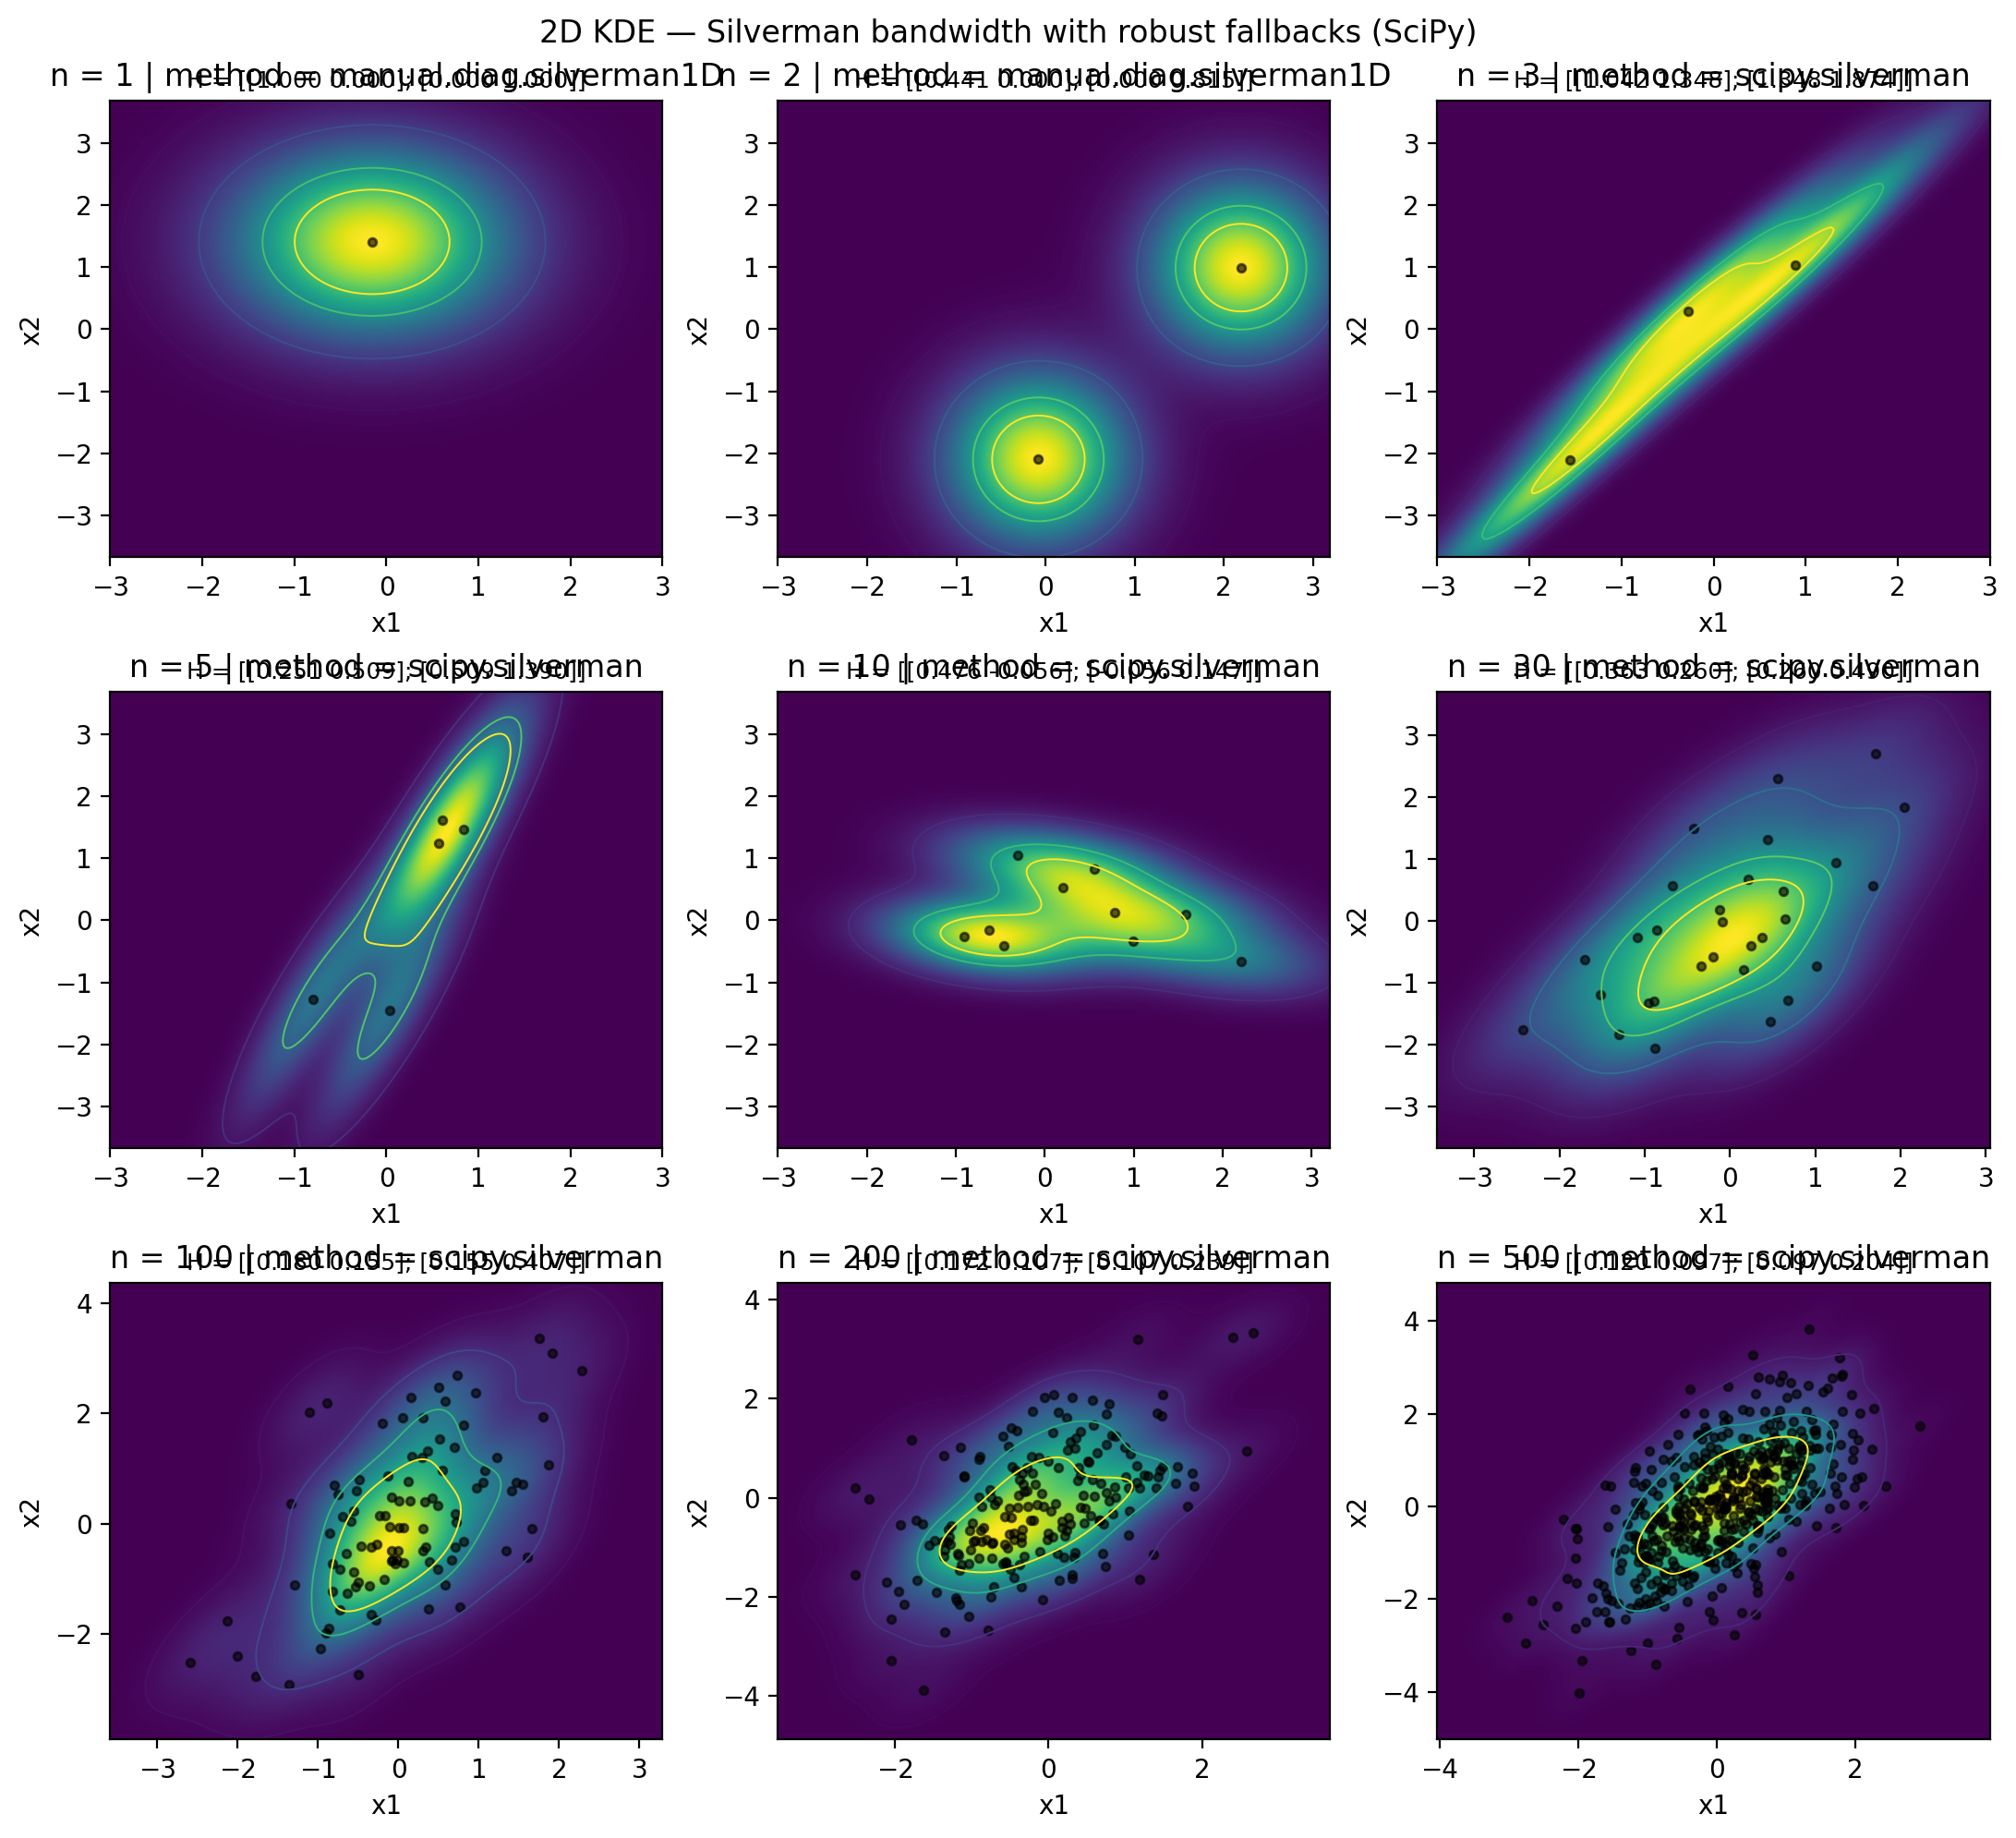


===== Bandwidth matrices (H) by sample size (SciPy/Silverman) =====
n =   1 | method =  manual.diag.silverman1D | H =
[[1. 0.]
 [0. 1.]]

n =   2 | method =  manual.diag.silverman1D | H =
[[0.441027 0.      ]
 [0.       0.814624]]

n =   3 | method =          scipy.silverman | H =
[[1.042184 1.34791 ]
 [1.34791  1.873693]]

n =   5 | method =          scipy.silverman | H =
[[0.250721 0.508759]
 [0.508759 1.389643]]

n =  10 | method =          scipy.silverman | H =
[[ 0.475609 -0.056267]
 [-0.056267  0.146848]]

n =  30 | method =          scipy.silverman | H =
[[0.36313  0.260136]
 [0.260136 0.490287]]

n = 100 | method =          scipy.silverman | H =
[[0.180426 0.154901]
 [0.154901 0.406686]]

n = 200 | method =          scipy.silverman | H =
[[0.172189 0.106896]
 [0.106896 0.238554]]

n = 500 | method =          scipy.silverman | H =
[[0.120333 0.097376]
 [0.097376 0.204372]]



In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


np.random.seed(44)

# ---------- 数据生成分布：二维高斯（带相关） ----------
mu = np.array([0.0, 0.0])
Sig = np.array([[1.0, 0.7],
                [0.7, 1.5]])

# 测试的样本量
N_LIST = [1, 2, 3, 5, 10, 30, 100, 200, 500]

# ---------- 1D Silverman 带宽（用作回退时的对角带宽） ----------
def silverman_bandwidth_1d(xs, min_h=1e-6):
    xs = np.asarray(xs, dtype=float)
    n = len(xs)
    if n <= 1:
        return 1.0  # 任意正数；回退时会很平滑
    mu = np.mean(xs)
    sd = np.sqrt(np.mean((xs - mu) ** 2))  # population std
    q75, q25 = np.percentile(xs, [75, 25])
    iqr = q75 - q25
    h = 0.9 * min(sd, iqr / 1.34) * (n ** (-1 / 5.0))
    if not np.isfinite(h) or h <= 0:
        h = 1.0
    return max(h, min_h)

# ---------- 回退：对角带宽手写 2D KDE（高斯核乘积） ----------
def eval_diag_gaussian_kde(X, h1, h2, grid_x, grid_y):
    """
    X: (n,2) 样本
    h1,h2: 两个维度的带宽
    grid_x, grid_y: 2D 网格 (meshgrid 返回)
    返回：与网格同形状的密度矩阵
    """
    n = X.shape[0]
    if n == 0:
        return np.full_like(grid_x, 1e-300, dtype=float)

    # 常数项 (1/(2π h1 h2))
    norm_const = 1.0 / (2.0 * np.pi * h1 * h2)

    # 展平网格，便于向量化
    gx = grid_x.ravel()[:, None]  # (G,1)
    gy = grid_y.ravel()[:, None]  # (G,1)

    # 对每个样本做叠加：prod_{d=1..2} N(gd; xi_d, h_d^2)
    dx = (gx - X[:, 0][None, :]) / h1
    dy = (gy - X[:, 1][None, :]) / h2
    # 高斯核：exp(-0.5 * (dx^2 + dy^2))
    K = np.exp(-0.5 * (dx ** 2 + dy ** 2))
    dens = norm_const * (K.mean(axis=1))  # (G,)
    dens = dens.reshape(grid_x.shape)
    # 数值下限
    dens = np.maximum(dens, 1e-300)
    return dens

# ---------- 主估计函数：优先用 scipy 的 Silverman，多重回退 ----------
def robust_kde_silverman(X):
    """
    优先：scipy.stats.gaussian_kde(bw_method='silverman')
    回退1：对角带宽（两维分别用 1D Silverman），手写乘积核 KDE
    返回：
      dict(method=..., H=2x2 numpy array, evaluator=callable(grid_x,grid_y)->dens)
    """
    X = np.asarray(X, dtype=float)
    n = X.shape[0]

    # 初始：尝试 scipy 的 gaussian_kde（full covariance with Silverman factor）
    if n >= 2:  # 避免明显的 n<=d 错误（对 2D 至少 3 更稳，但 2 也可能工作）
        try:
            kde = gaussian_kde(X.T, bw_method="silverman")  # 注意：输入形状 (d, n)
            # SciPy 中的协方差矩阵（对应核的协方差）：
            H = kde.covariance  # = (covariance_factor^2)*data.cov
            def eval_scipy(grid_x, grid_y):
                pts = np.vstack([grid_x.ravel(), grid_y.ravel()])  # (2, G)
                dens = kde(pts).reshape(grid_x.shape)
                return np.maximum(dens, 1e-300)
            return dict(method="scipy.silverman", H=H, evaluator=eval_scipy)
        except (ValueError, LinAlgError):
            pass  # 退到对角带宽

    # 回退：对角带宽（各维 1D Silverman），手写乘积高斯核
    if n == 0:
        H = np.diag([1.0, 1.0]).astype(float)
        def eval_empty(grid_x, grid_y):
            return np.full_like(grid_x, 1e-300, dtype=float)
        return dict(method="manual.diag.empty", H=H, evaluator=eval_empty)

    h1 = silverman_bandwidth_1d(X[:, 0])
    h2 = silverman_bandwidth_1d(X[:, 1])
    H = np.diag([h1 ** 2, h2 ** 2])

    def eval_diag(grid_x, grid_y):
        return eval_diag_gaussian_kde(X, h1, h2, grid_x, grid_y)

    return dict(method="manual.diag.silverman1D", H=H, evaluator=eval_diag)

# ---------- 绘图工具：按密度分位数画等高填充 ----------
def filled_contour_by_quantiles(ax, Z, levels=(0.25, 0.5, 0.75, 0.9, 0.95)):
    # 根据密度取分位数作为等高线高度
    qs = np.quantile(Z, levels)
    cs = ax.contourf(Z, levels=qs)
    return cs

# ---------- 主程序 ----------
def main():
    # 画布布局
    k = len(N_LIST)
    nc = int(np.ceil(np.sqrt(k)))
    nr = int(np.ceil(k / nc))
    fig, axes = plt.subplots(nr, nc, figsize=(3.6*nc, 3.2*nr), constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    results = []

    for i, n in enumerate(N_LIST):
        ax = axes[i]

        # 采样
        X = np.random.multivariate_normal(mean=mu, cov=Sig, size=n)

        # 估计
        fit = robust_kde_silverman(X)
        H = fit["H"]
        method = fit["method"]

        # 设定网格范围（均值±3σ 的并集）
        stds = np.sqrt(np.diag(Sig))
        x1_min, x1_max = (mu[0] - 3*stds[0], mu[0] + 3*stds[0])
        x2_min, x2_max = (mu[1] - 3*stds[1], mu[1] + 3*stds[1])

        # 若样本范围更极端，就扩展边界
        if n > 0:
            x1_min = min(x1_min, np.min(X[:, 0]) - 1.0)
            x1_max = max(x1_max, np.max(X[:, 0]) + 1.0)
            x2_min = min(x2_min, np.min(X[:, 1]) - 1.0)
            x2_max = max(x2_max, np.max(X[:, 1]) + 1.0)

        xx = np.linspace(x1_min, x1_max, 200)
        yy = np.linspace(x2_min, x2_max, 200)
        GX, GY = np.meshgrid(xx, yy)

        # 评估密度
        Z = fit["evaluator"](GX, GY)

        # 绘图：密度热力 + 等高 + 样本点
        im = ax.imshow(Z, origin="lower",
                       extent=[xx.min(), xx.max(), yy.min(), yy.max()],
                       aspect="auto")
        ax.contour(xx, yy, Z, levels=np.quantile(Z, [0.25, 0.5, 0.75, 0.9, 0.95]),
                   linewidths=0.7)
        if n > 0:
            ax.scatter(X[:, 0], X[:, 1], s=10, c="k", alpha=0.6)
        ax.set_title(f"n = {n} | method = {method}")
        ax.set_xlabel("x1"); ax.set_ylabel("x2")

        # 在标题下方打印 H（简化显示）
        h_str = f"H = [[{H[0,0]:.3f} {H[0,1]:.3f}]; [{H[1,0]:.3f} {H[1,1]:.3f}]]"
        ax.text(0.5, 1.02, h_str, transform=ax.transAxes, ha="center", va="bottom", fontsize=9)

        results.append((n, method, H.copy()))

    # 关闭多余子图
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("2D KDE — Silverman bandwidth with robust fallbacks (SciPy)", y=1.02, fontsize=12)
    plt.show()

    # 控制台打印 H
    print("\n===== Bandwidth matrices (H) by sample size (SciPy/Silverman) =====")
    for n, method, H in results:
        print(f"n = {n:>3} | method = {method:>24} | H =")
        print(H.round(6))
        print()

if __name__ == "__main__":
    main()